# Root

## Imports

In [1]:
# Loading Data & Functions #
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt     # for plotting
import numpy as np                  # for reshaping array manipulation
import cv2                          # for image loading and colour conversion
import tensorflow as tf             # for bulk image resize
import glob
import random
import keras
from sklearn import discriminant_analysis
from sklearn import decomposition
from sklearn.decomposition import IncrementalPCA
import numpy
from sklearn.manifold import TSNE
import tensorflow as tf             # for bulk image resize
import keras

from keras.layers import Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, Input, Flatten, MaxPool2D, SpatialDropout2D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import random
import copy

import preprocessing as pre
from sklearn.model_selection import train_test_split


## Filepath

In [2]:
path = './Processed_Images_Square/'
filename_list = './file_names.txt'
image_dimensions = (350,350,3)

## Utility Functions

### Data import functions

In [1]:
def split_number_into_intervals(number, num_intervals):
    # Calculate the size of each interval
    base_size = number // num_intervals
    remainder = number % num_intervals
    
    intervals = [base_size] * num_intervals
    
    # Distribute the remainder among the intervals
    for i in range(remainder):
        intervals[i] += 1
    
    return intervals


def load_directory(base_path, category, split_num):

    # find all images in the directory
    x = []
    y = []
    prev_dog_num = None
    cont = 0

    with open(filename_list, "r") as file:
    # Read and process each line
        for f in file:
            # Strip the newline character and print the line
            dog_num = int(f.strip().split('_')[0])
            batch_size = split_number_into_intervals(category[dog_num],3)
            # print("batch Size", batch_size)

            if(prev_dog_num != dog_num):
                cont = 0
                prev_dog_num = dog_num

            # print("dognum", dog_num)
            
            # Check conditions based on c
            if split_num == 1 and cont > batch_size[0]:
                continue
            elif split_num == 2 and not (batch_size[0] <= cont <= (batch_size[1] + batch_size[0]+ 1)):
                continue
            elif split_num == 3 and not ((batch_size[1] + batch_size[0]) <= cont <= (batch_size[1] + batch_size[0]+batch_size[2] +1)):
                continue
            
            file = os.path.join(base_path, f.strip())
            # Process the file
            x.append(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) / 255.0)
            y.append(dog_num)
            print("successful imported", f)
            cont += 1
        
    return np.array(x), np.array(y)

def load_data(base_path,category, split_num):
    
    # load training data
    rawX, rawY = load_directory(base_path,category, split_num)
    X_train, X_test, y_train, y_test = train_test_split(rawX, rawY, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test
    


### Preprocessing Functions

In [ ]:
def gen_files(batch_size):
    files = glob.glob(path + '*.jpg')

    while True:
        x = []
        y = []
        for i in range(batch_size):
            f = random.choice(files)
            x.append(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) / 255.0)
            f = f.split('/')[-1]
            dog_num = float(f.split('_')[0])
            y.append(dog_num)

        yield np.array(x), np.array(y)


def gen_files_vec(batch_size):
    image_generator = gen_files(batch_size)

    while True:
        x, y = next(image_generator)


        yield vectorise(x), y

def vectorise(images):
    # use numpy's reshape to vectorise the data
    return np.reshape(images, [len(images), -1])


def plot_images(images, labels):
    fig = plt.figure(figsize=[15, 18])
    loop_count = 50
    if len(images) < 50:
        loop_count = len(images)
    for i in range(loop_count):
        ax = fig.add_subplot(8, 6, i + 1)
        ax.imshow(images[i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title(labels[i])
        ax.axis('off')


def get_siamese_data(batch_size):

    while True:
        files = glob.glob(path + '*.jpg')

        images = []
        labels = []

        for i in range(int(batch_size / 2)):
            ## Get original dog

            f = random.choice(files)
            original_dog = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) / 255.0


            ## Get matching pair
            f = f.split('/')[-1]
            dog_num = f.split('_')[0]

            matching_breed_files = glob.glob(path + dog_num + '*.jpg')
            matching_breed_files_without_original = copy.deepcopy(matching_breed_files)
            matching_breed_files_without_original.remove(path + f)

            matching_dog = random.choice(matching_breed_files)
            pair_dog = cv2.cvtColor(cv2.imread(matching_dog), cv2.COLOR_BGR2RGB) / 255.0

            images.append((original_dog, pair_dog))
            labels.append(1.0)

            ## Get non-matching pair
            non_matching_breed_files = [x for x in files if x not in matching_breed_files]

            non_matching_dog = random.choice(non_matching_breed_files)
            non_pair_dog = cv2.cvtColor(cv2.imread(non_matching_dog), cv2.COLOR_BGR2RGB) / 255.0

            images.append((original_dog, non_pair_dog))
            labels.append(0.0)


        yield np.array(images), np.array(labels)


def plot_pairs(x, y):
    fig = plt.figure(figsize=[25, 6])
    for i in range(10):
        ax = fig.add_subplot(2, 10, i*2 + 1)
        ax.imshow(x[i][0,:])
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))

        ax = fig.add_subplot(2, 10, i*2 + 2)
        ax.imshow(x[i][1,:])
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))



def plot_tsne(data_x, data_y):
    tsne_embeddings = TSNE(random_state=4).fit_transform(data_x)
    fig = plt.figure(figsize=[12, 12])
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = data_y.flatten());


def cmc_to_top(cmc, verbose=True):
    top1 = cmc[0]
    top5 = cmc[4]
    top10 = cmc[9]

    if verbose:
        print(f'Top 1: {top1}')
        print(f'Top 5: {top5}')
        print(f'Top 10: {top10}')

    return top1, top5, top10


## Load Data

1. Count the number of images in each categories
2. Split it loading into three times
3. Combine all training and testing sets
4. Print shape to confirm a successful import


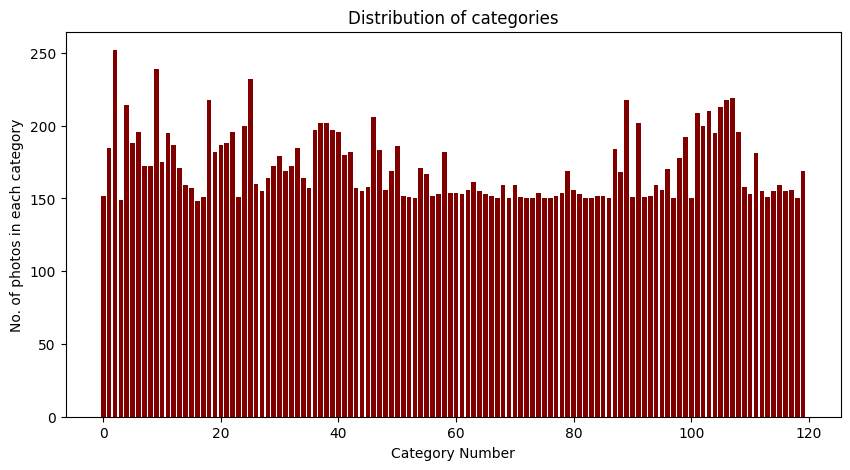

In [4]:
category = pre.count_categories()

In [5]:
train_X, train_Y, test_X, test_Y = load_data(path,category, 1)

successful imported 00_7.jpg 

successful imported 00_199.jpg 

successful imported 00_242.jpg 

successful imported 00_275.jpg 

successful imported 00_326.jpg 

successful imported 00_368.jpg 

successful imported 00_382.jpg 

successful imported 00_431.jpg 

successful imported 00_473.jpg 

successful imported 00_477.jpg 

successful imported 00_500.jpg 

successful imported 00_574.jpg 

successful imported 00_575.jpg 

successful imported 00_588.jpg 

successful imported 00_712.jpg 

successful imported 00_730.jpg 

successful imported 00_735.jpg 

successful imported 00_806.jpg 

successful imported 00_949.jpg 

successful imported 00_952.jpg 

successful imported 00_1073.jpg 

successful imported 00_1152.jpg 

successful imported 00_1205.jpg 

successful imported 00_1235.jpg 

successful imported 00_1271.jpg 

successful imported 00_1298.jpg 

successful imported 00_1321.jpg 

successful imported 00_1346.jpg 

successful imported 00_1455.jpg 

successful imported 00_1492.jpg 

su

: 